In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.detection_dataset_loader import *
from scipy.spatial.transform import Rotation as R
from data.data_utils.data_reader import *
from data.data_utils.reader_utils import *
import math
import numpy.matlib as npm

from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [17]:
def get_augmentation_parameters( training):
        if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-20, 20)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-20, 20)
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.3:
                        ang = random.randint(-5, 5)
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 2
                    sc_z = 1

                    if np.random.random_sample() >= 0.5:
                       sc_x += ((random.random() * 2) - 1.) / 10.

                    if np.random.random_sample() >= 0.5:
                       sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    
                    fliplr = np.random.random_sample() >= 0.5

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    
                    fliplr = False

        return rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr

In [18]:
training=True
base_path = '../../../Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3/')))
# print(len(list_files))
# random.seed(0)
# random.shuffle(list_files)
if True:
    file_name = '/train.txt'
else:
    file_name = '/val.txt'
with open(base_path + file_name, 'r') as f:
            list_file_nums = f.readlines()
list_files = [ l.strip() for l in list_file_nums]

            


label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files[:]))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files[:]))


# camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
# lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
# label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
# calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

list_files = list_files[:]
list_label_paths = label_paths[:]
list_calib_paths = calib_paths[:]

In [19]:
def get_target2(labels, truncated, occlusion, anchors=np.array([3.9, 1.6, 1.5]), input_size=(448, 512), output_size=(112, 128, 35)):
    ratio = input_size[0] // output_size[0]
    ratio = 1
    y_target = np.zeros((output_size[0], output_size[1], 2, 13), np.float32)
    for i in range(len(labels)):
        label_i = np.array(labels[i])

        x = int(label_i[0]/ratio)
        y = int(label_i[1]/ratio)

        if x >= output_size[0]:
            x = output_size[0] - 1
        if y >= output_size[1]:
            y = output_size[1] - 1

        if x < 0 or y < 0:
            continue

        # label_i[0:2] = label_i[0:2] / (ratio*1.0)
        label_i[2] = label_i[2] / (output_size[2]*1.)
        ang = label_i[6]

        if ang < 0:
          dir_ = 0
        else:
          dir_ = 1
        while ang < 0:
          ang += np.pi
        k = 0
        if (ang > np.pi/4 and ang < (3/4.)* np.pi) or (ang < -np.pi/4 and ang > -(3./4.)* np.pi):
          k = 1

        if ang > (3./4.) * np.pi:
          ang -= np.pi
        label_i[6] = ang - k * (np.pi/2)
        label_i = np.append(label_i, [dir_])
        
        anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
    
        label_i[:3] = (label_i[:3] - anchor[:3]) 
        label_i[3:6] = np.log(label_i[3:6])

#         mins = np.array([-0.5, -0.5, 0, 0.8, 0.3, 0.13, -1.1, -1.1])
#         maxs = np.array([0.5, 0.5, 1, 2.6, 1.4, 0.82, 1.1, 1.1])
        mins = np.array([0, 0, 0, -0.1, -0.1, -0.1, -1.1, -1.1])
        maxs = np.array([0, 0, 0, 3, 2, 2, 1.1, 1.1])
        
        label_i[3:6] = ((label_i[3:6] - mins[3:6]) / (maxs[3:6]-mins[3:6])) * 2 - 1
        z = [0, 0, 0, 0]
        z[occlusion[i]] = 1

        y_target[x, y, k, :8] = label_i
        y_target[x, y, k, 8:9] = [1]
        y_target[x, y, k, 9:13] = z
        
    return y_target

In [20]:
new_labels = []
max_labels = []
for i_c in range(len(list_files)):
    rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(True)
    data_reader_obj = DataReader(None,
                                 list_calib_paths[i_c], 
                                 list_label_paths[i_c], 
                                 None, 
                                 rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False, fliplr=fliplr)
    _, label, truncated, occlusion = data_reader_obj.read_label()
    label2 = get_target(label, truncated, occlusion, anchors=np.array([3.9, 1.6, 1.5]))
    new_labels.extend(label2)

In [21]:
new_labels = np.array(new_labels)

In [22]:
for i in range(8):
    print("i = ", i, ", min = ", np.min(new_labels[:, :, :, i]), ", max = ", np.max(new_labels[:, :, :, i]))

i =  0 , min =  -0.49998975 , max =  0.49981305
i =  1 , min =  -0.4999575 , max =  0.49991935
i =  2 , min =  -0.39025956 , max =  0.4961353
i =  3 , min =  -0.4738529 , max =  0.73042744
i =  4 , min =  -0.68063706 , max =  0.44166318
i =  5 , min =  -0.7799731 , max =  0.0
i =  6 , min =  -0.7842971 , max =  0.7850934
i =  7 , min =  0.0 , max =  1.0


In [39]:
for i in range(8):
    print("i = ", i, ", min = ", np.min(new_labels[:, :, :, i]), ", max = ", np.max(new_labels[:, :, :, i]))

i =  0 , min =  -0.49985272 , max =  0.49995843
i =  1 , min =  -0.49997813 , max =  0.49999264
i =  2 , min =  -0.39025956 , max =  0.4961353
i =  3 , min =  -0.99777603 , max =  0.21957763
i =  4 , min =  -1.3072213 , max =  0.0
i =  5 , min =  -0.9970195 , max =  1.255822
i =  6 , min =  -0.78159267 , max =  0.78159267
i =  7 , min =  0.0 , max =  1.0


In [9]:
for i in range(8):
    print("i = ", i, ", min = ", np.min(new_labels[:, i]), ", max = ", np.max(new_labels[:, i]))

i =  0 , min =  -0.49999299862620816 , max =  0.4999807417197495
i =  1 , min =  -0.4999349434847602 , max =  0.49983609717586575
i =  2 , min =  -0.3902595577127191 , max =  0.4961353037370957
i =  3 , min =  0.8020267138550041 , max =  2.590198504028226
i =  4 , min =  0.3146345576980875 , max =  1.3812716659764364
i =  5 , min =  0.1310282624064038 , max =  0.810930216216329
i =  6 , min =  -0.9999998142567856 , max =  0.9999998142567856
i =  7 , min =  -1.0 , max =  1.0


(array([   8.,  104., 1305., 4762., 3925., 1728.,  786.,  276.,  126.,
          14.]),
 array([-0.99701953, -0.7999465 , -0.60287347, -0.40580044, -0.20872741,
        -0.01165438,  0.18541865,  0.38249168,  0.57956471,  0.77663774,
         0.97371077]),
 <a list of 10 Patch objects>)

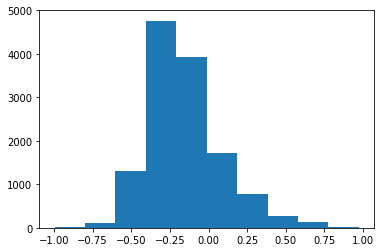

In [28]:
plt.hist(new_labels[:, 5])

(array([1283., 1249., 1315., 1298., 1357., 1407., 1282., 1267., 1298.,
        1295.]),
 array([-4.99830863e-01, -3.99861966e-01, -2.99893069e-01, -1.99924172e-01,
        -9.99552754e-02,  1.36214511e-05,  9.99825183e-02,  1.99951415e-01,
         2.99920312e-01,  3.99889209e-01,  4.99858106e-01]),
 <a list of 10 Patch objects>)

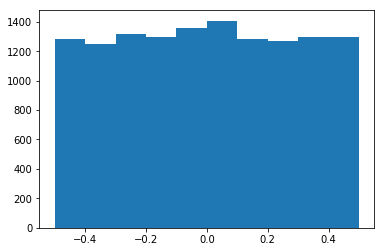

In [33]:
plt.hist(new_labels[:, 0])

(array([2.000e+00, 3.000e+00, 2.100e+01, 4.100e+01, 9.500e+01, 2.450e+02,
        5.590e+02, 1.269e+03, 3.193e+03, 7.623e+03]),
 array([-8.68479956e+00, -7.81633379e+00, -6.94786803e+00, -6.07940226e+00,
        -5.21093650e+00, -4.34247073e+00, -3.47400496e+00, -2.60553920e+00,
        -1.73707343e+00, -8.68607670e-01, -1.41904498e-04]),
 <a list of 10 Patch objects>)

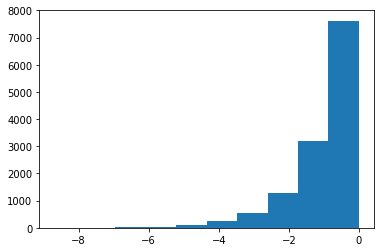

In [35]:
plt.hist(np.log(new_labels[:, 0]+0.5))

In [7]:
list_angles = np.array(list_angles)
list_original_angles = np.array(list_original_angles)
list_angles_0 = np.array(list_angles_0)
list_angles_1 = np.array(list_angles_1)

In [8]:
np.max(list_angles), np.min(list_angles)

(0.7815926535897932, -0.7815926535897932)

In [9]:
np.max(list_angles_0), np.min(list_angles_0)

(0.7815926535897932, -0.7815926535897932)

In [10]:
np.max(list_angles_1), np.min(list_angles_1)

(2.351592653589793, 0.79)

In [11]:
np.max(list_original_angles), np.min(list_original_angles)

(3.14, 0.0)

In [19]:
np.max(list_angles), np.min(list_angles)

(0.7800000000000002, -0.7815926535897932)

In [20]:
np.max(list_original_angles), np.min(list_original_angles)

(3.14, 0.0)

In [23]:
np.pi, np.pi/2, np.pi/4

(3.141592653589793, 1.5707963267948966, 0.7853981633974483)

In [7]:
i_c = 3
rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)
data_reader_obj = DataReader(None,
                                 list_calib_paths[i_c], 
                                 list_label_paths[i_c], 
                                 None, 
                                 rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False, fliplr=fliplr)
_, label, directions = data_reader_obj.label_reader.read_label()
label2 = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

In [9]:
len(label), label

(1, array([[278.3097315 , 178.11101949,  26.43074065,   4.26      ,
           1.74      ,   1.47      ,   3.09      ]]))

In [10]:
np.where(label2[:, :, :, 8] >= 0.5)

(array([69]), array([44]), array([0]))

In [11]:
label2[69, 44, 0, :]

array([ 0.01985458,  0.0173468 , -0.22615433,  0.08829261,  0.08388148,
       -0.02020271, -0.05159265,  1.        ,  1.        ], dtype=float32)

In [41]:
np.log(1.74/1.6)

0.08388148398070203

In [56]:
np.log(2/1.6), 2/1.6, np.log(2.5/1.6), 2.5/1.6

(0.22314355131420976, 1.25, 0.44628710262841953, 1.5625)

In [49]:
(abs(0.22314355131420976-0.08388148398070203)**2) * 0.5

0.009696961699001222

In [40]:
np.exp(0.08829261) * 3.9

4.26000001215941

In [42]:
temp = 277
# temp = 278.3097315
((temp/4 - temp//4) - 0.5)/3.9, temp//4

(-0.06410256410256411, 69)

In [45]:
abs(-0.06410256410256411 - 0.01985458) - 0.5

-0.4160428558974359

In [ ]:
0.06410256410256411

In [25]:
(0.01985458*3.9 + 69.5) * 4

278.309731448

In [54]:
(0.01985458*3.9 + .5), (0.01985458*3.9 + .5) * 4

(0.577432862, 2.309731448)

In [16]:
0.01985458*3.9 + 0.5, 0.0173468*1.6 + 0.5, -0.22615433*1.5 + 1

(0.577432862, 0.52775488, 0.6607685050000001)

In [17]:
278.3097315 / 4, 278.3097315//4, 178.11101949/4, 178.11101949//4, 26.43074065/40, 26.43074065//40

(69.577432875, 69.0, 44.5277548725, 44.0, 0.66076851625, 0.0)

In [20]:
69.577432875 * 4

278.3097315

In [21]:
(0.3097315 - 0.5) / 3.9

-0.048786794871794874

In [23]:
(0.577432875 - 0.5) / 3.9

0.01985458333333332